In [1]:
import functools

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score

from sm_analysis.utils import *
from sm_analysis.twitter import *
from sm_analysis.topic_modeling import *

In [2]:
pd.set_option('display.max_colwidth', 50)

# reproducible rng
seed = 0

plt.style.use("bmh")
%matplotlib inline

# suppress stop words mismatch warning
import warnings
warnings.simplefilter('ignore')

In [3]:
COLS = ['user_screen_name',
        'user_reported_location',
        'user_profile_description',
        'account_language']

### Data

In [4]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]
campaign = df[df['campaign'] == 'iran202012']
campaign_users = user_df[user_df['campaign'] == 'iran202012']

In [5]:
user_tweets = (campaign
               .groupby('userid')[['tweet_text']]
               .agg(string_agg)
              )
print(user_tweets.head(5))

                                                                                     tweet_text
userid                                                                                         
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=   [America and the way its government treats its...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=  [@ManotoNews اگه ایران به یمن و مقاومت کمک نکن...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=  [People are not silent! This structure must ch...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=   [El pueblo indígena Kayapo cerró una important...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=  [@VoteMarsha Why Women Prefer to Vote for an r...


### Vectorize

In [5]:
stop_words = [*stopwords.words(),
              '[url]', '[at]', '[htag]',
             ]
tokenize_partial = functools.partial(tokenize_string, stop_words=stop_words)
preprocess_partial = functools.partial(preprocess_string, special_tokens=False)

vectorizer = CountVectorizer(analyzer='word',
                             strip_accents='ascii',
                             stop_words=stop_words,
                             ngram_range=(1,2),
                             preprocessor=preprocess_partial,
                             tokenizer=tokenize_partial,
                             max_features=2000,
                            )

In [6]:
documents_list = (user_tweets['tweet_text']
                  .map(long_string)
                  .map(preprocess_string)
                   )

In [7]:
matrix = vectorizer.fit_transform(documents_list)

## Clustering

In [9]:
def k_means_cluster(matrix, k):

    print('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1, random_state=seed)
    model.fit(matrix)
    labels = model.labels_
    metrics = [silhouette_score(matrix, labels), model.inertia_]
            
    return model, metrics

In [10]:
k = 10
model, metrics = k_means_cluster(matrix, k)

fitting model for 10 clusters


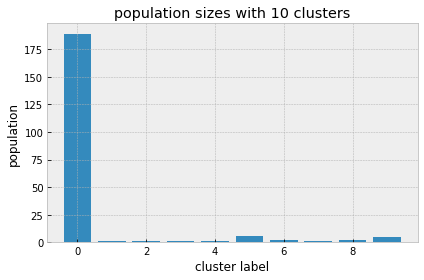

In [12]:
fig, ax = plt.subplots()

ax.bar(range(len(set(model.labels_))), np.bincount(model.labels_))

ax.set_ylabel('population')
ax.set_xlabel('cluster label')
ax.set_title('population sizes with {} clusters'.format(k))
    
fig.tight_layout()

Users are grouped into 10 clusters based on the contents of their tweets.

In [13]:
user_tweets['cluster'] = model.labels_

Cluster sizes:

In [14]:
sizes = (user_tweets
       .groupby('cluster')
       .size()
       .sort_values(ascending=False)
       )
print(sizes)

cluster
0    189
5      6
9      5
8      2
6      2
7      1
4      1
3      1
2      1
1      1
dtype: int64


In [15]:
idx = sizes.index[0]

top_cluster = (user_tweets
           .groupby('cluster')
           .get_group(idx)['tweet_text']
           .apply(long_string)
          )
print(top_cluster.head(5))

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     America and the way its government treats its ...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    @ManotoNews اگه ایران به یمن و مقاومت کمک نکنه...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    People are not silent! This structure must cha...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     El pueblo indígena Kayapo cerró una importante...
1099221870530961408                             Droit de vote à 16ans, vous êtes ?\nEt pourquo...
Name: tweet_text, dtype: object


In [19]:
cluster_ids = (top_cluster
              .reset_index()['userid'])
user_info = (campaign_users
            .loc[campaign_users.index.isin(cluster_ids)])
print(user_info[COLS].sample(10))

                                                                          user_screen_name  \
userid                                                                                       
JNDaZpeNuHOsxlhmPviGGKe9xF453u8IYPdgQXlas=      JNDaZpeNuHOsxlhmPviGGKe9xF453u8IYPdgQXlas=   
ZgCb427kj9cmB6mehFV4lpaTC5p+TQL+eRvj5qKxCws=  ZgCb427kj9cmB6mehFV4lpaTC5p+TQL+eRvj5qKxCws=   
O2v43Q2piVdfKPC6mJtJmo4O0JBPtMG2F4CucMA3FA=    O2v43Q2piVdfKPC6mJtJmo4O0JBPtMG2F4CucMA3FA=   
n5lz9VsZpaWmJiE+6DqqGUbKkjppojceXJnnvYwFiCk=  n5lz9VsZpaWmJiE+6DqqGUbKkjppojceXJnnvYwFiCk=   
HcrkAj2Z5laESkAd3aQjE1dgoP6r9xDN6LLzEIHzX4=    HcrkAj2Z5laESkAd3aQjE1dgoP6r9xDN6LLzEIHzX4=   
XtCe1ymc2CW5y7mTkbZ5xD8m10ToIX1MAwub8lz3k=      XtCe1ymc2CW5y7mTkbZ5xD8m10ToIX1MAwub8lz3k=   
LM4nkVAt6L4SenHC5Bqu89+Cj2aP76EnskDsx45R9Ek=  LM4nkVAt6L4SenHC5Bqu89+Cj2aP76EnskDsx45R9Ek=   
9UjR+zH6EWn49YJJ9getgrivUHqgYjZCdiWkFZcf4s=    9UjR+zH6EWn49YJJ9getgrivUHqgYjZCdiWkFZcf4s=   
uA73TTeDiYFMngplc4rK+AvquWpIfpMbH9iVB8lMA=      uA73TTeDiYFM

This word cloud shows the frequent word tokens used by users in the largest cluster:

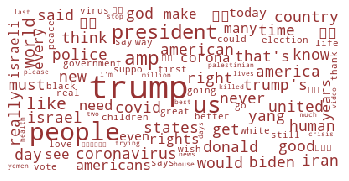

In [20]:
fig = vis_from_series(top_cluster)

In [21]:
idx = sizes.index[1]
cluster = (user_tweets
           .groupby('cluster')
           .get_group(idx)['tweet_text']
           .apply(long_string)
          )
print(cluster.head(5))

userid
6qhrzJLryTiE7VlJkmY+cKE5VsITiaFwMA7s3Dr5I=      Sungguh bodoh orang yang tidak mau membela ban...
79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=    god will punish you Aung San Suu Kyi #ShameOnA...
BYaaZkKxjVQjhsnn9REZ0UcFoEHl+tKnzJ+0Hv+Pg=      the camps which have been thought to be places...
ihPCMQ32xEzpD35Et9IH4HO21XKiWdSJreVg+pHT5o=     #Palestine \n#PalestineWillBeFree \n#Palestine...
rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=      #GoodThingsComeToThoseWho follow the supreme r...
Name: tweet_text, dtype: object


Second-largest cluster:

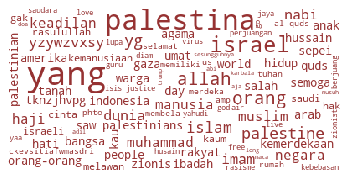

In [22]:
fig = vis_from_series(cluster)